In [17]:
!git clone https://github.com/cswin/KerasTutorial.git
  

Cloning into 'KerasTutorial'...
remote: Enumerating objects: 475, done.
remote: Counting objects: 100% (475/475), done.
remote: Compressing objects: 100% (461/461), done.
remote: Total 475 (delta 22), reused 449 (delta 10), pack-reused 0
Receiving objects: 100% (475/475), 39.79 MiB | 24.09 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [18]:
!ls


0label.png  0test.png  KerasTutorial  sample_data  u-net-architecture.png


In [0]:

# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [20]:

print(os.listdir("KerasTutorial/UNet/data/"))

FAST_RUN = False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_CHANNELS=1 # gray 
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS)


traindata_path_images = "KerasTutorial/UNet/data/train/image/"
traindata_path_labels = "KerasTutorial/UNet/data/train/label/"
testdata_path = "KerasTutorial/UNet/data/test/"


['test-volume.tif', 'train', 'train-volume.tif', 'validation', 'test', 'train-labels.tif']


KerasTutorial/UNet/data/train/image/9.png
KerasTutorial/UNet/data/train/label/9.png


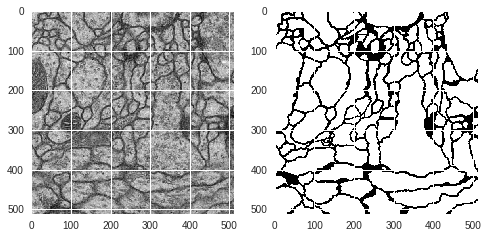

In [21]:

# show the sample image
filenames_train = os.listdir(traindata_path_images)
sample = random.choice(filenames_train)
print(traindata_path_images+sample)
image = load_img(traindata_path_images+sample)
plt.subplot(1, 2,1)
plt.imshow(image)

#show the corresponding labels
filenames_train = os.listdir(traindata_path_labels)
print(traindata_path_labels+sample)
image = load_img(traindata_path_labels+sample)
plt.subplot(1, 2,2)
plt.imshow(image)
plt.show()

In [0]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

In [0]:
def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

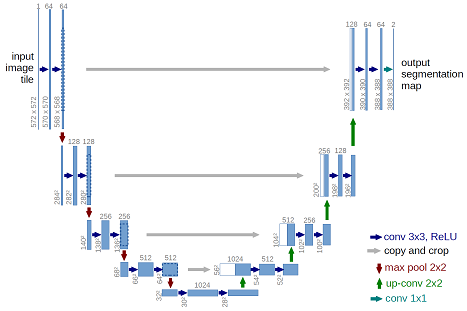

In [24]:
from IPython.display import Image
Image('u-net-architecture.png')

In [0]:
#Build Model

import skimage.io as io
import skimage.transform as trans

from keras.optimizers import Adam
from keras import backend as keras

from keras.models import Model, Sequential

from keras.layers import Input, Conv2D, MaxPooling2D, Dropout 
from keras.layers import Flatten, Dense, Activation, BatchNormalization, UpSampling2D
from keras.layers.merge import Concatenate

There are two ways to build Keras models: sequential and functional.

The sequential API allows you to create models layer-by-layer for most problems. 
It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.

Alternatively, the functional API allows you to create models that have a lot more flexibility as you can 
easily define models where layers connect to more than just the previous and next layers. In fact, 
you can connect layers to (literally) any other layer. 
As a result, creating complex networks such as siamese networks and residual networks become possible.

https://jovianlin.io/keras-models-sequential-vs-functional/
    

In [26]:
inputs = Input(IMAGE_SIZE)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1) 
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = Concatenate(axis = 3)([drop4,up6])
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = Concatenate(axis = 3)([conv3,up7])
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = Concatenate(axis = 3)([conv2,up8])
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = Concatenate(axis = 3)([conv1,up9])
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxP

In [0]:
#Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#
#Early Stop
#To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

earlystop = EarlyStopping(monitor='loss', patience=5)

#Learning Rate Reduction
#We will reduce the learning rate when then accuracy not increase for 3 steps

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.5)

checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)

callbacks = [earlystop, learning_rate_reduction, checkpoint]

In [29]:
#Fit Model
epochs=3 if FAST_RUN else 50
batch_size =2
total_train =30
total_validate =10
train_generator = trainGenerator(batch_size,'KerasTutorial/UNet/data/train','image','label',data_gen_args,save_to_dir = None)
validation_generator = trainGenerator(batch_size,'KerasTutorial/UNet/data/validation','image','label',data_gen_args,save_to_dir = None)
print(validation_generator)
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<generator object trainGenerator at 0x7fba8f71b570>
Epoch 1/50
Found 10 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
15/15 [==============================] - 21s 1s/step - loss: 0.5725 - acc: 0.7646 - val_loss: 0.4945 - val_acc: 0.8021

Epoch 00001: loss improved from inf to 0.57254, saving model to unet_membrane.hdf5
Epoch 2/50
15/15 [==============================] - 8s 509ms/step - loss: 0.4465 - acc: 0.7807 - val_loss: 0.4974 - val_acc: 0.8011

Epoch 00002: loss improved from 0.57254 to 0.44655, saving model to unet_membrane.hdf5
Epoch 3/50
15/15 [==============================] - 8s 503ms/step - loss: 0.3767 - acc: 0.7823 - val_loss: 0.3472 - val_acc: 0.7993

Epoch 00003: loss improved from 0.44655 to 0.37667, saving model to unet_membrane.hdf5
Epoch 4/50
15/15 [==============================] - 8s 502ms/step - loss: 0.3451 - acc: 0.8199 - val_loss: 0.3321 - val_acc: 0.8437

E

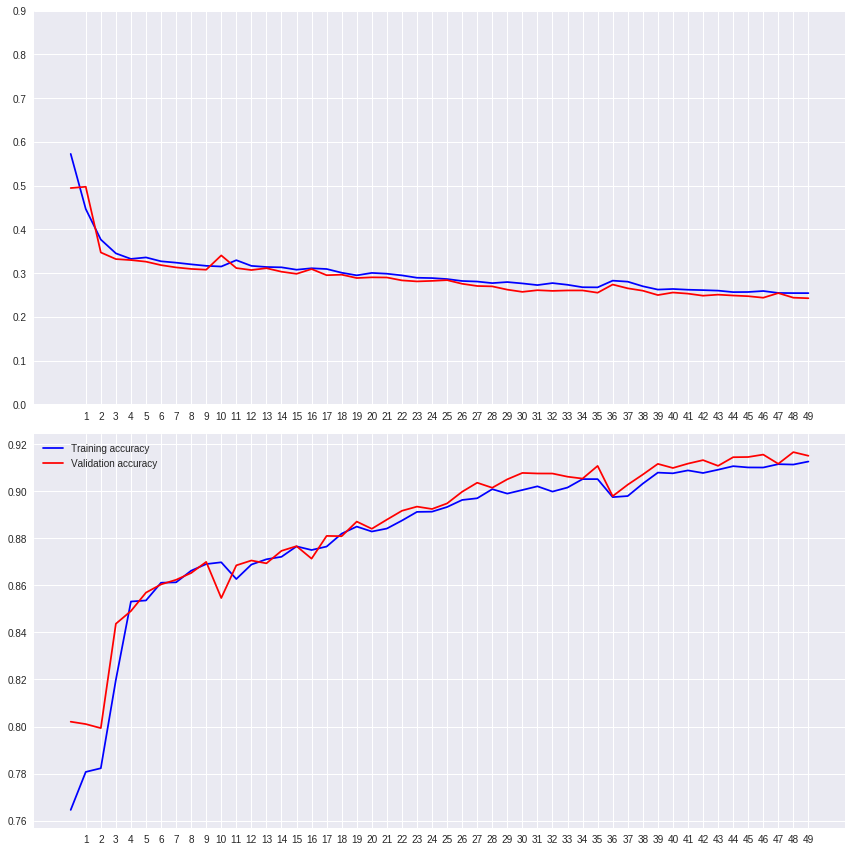

In [30]:
print(history)
#Virtualize Training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()